# In[1] - Imports & Data Loading

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Load the dataset
df = pd.read_csv('FIC.Full CSV.csv')

# Inspect top rows
df.head()

,Age,Age.Group,Gender,Locality,Marital status,Life.Style,Sleep,Category,Depression,Hyperlipi,...,oldpeak,slope,ca,thal,num,SK,SK.React,Reaction,Mortality,Follow.Up
0,45,41-50,Female,RURAL,MARRIED,NO,NO,FREE,YES,YES,...,3.0,2,0,7,2,1,NO,0,0,60
1,51,51-60,Female,URBAN,MARRIED,NO,NO,FREE,YES,YES,...,1.2,2,0,7,2,1,NO,0,0,15
2,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,...,3.4,2,0,3,2,1,NO,0,0,6
3,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,...,2.0,2,1,7,3,1,NO,0,0,52
4,56,51-60,Female,RURAL,MARRIED,YES,NO,FREE,YES,YES,...,4.0,3,2,7,3,1,NO,0,0,34


# In[2] - DataFrame Info & Missing Values

In [22]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 60 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   Age                                                                                       368 non-null    int64  
 1   Age.Group                                                                                 368 non-null    object 
 2   Gender                                                                                    368 non-null    object 
 3   Locality                                                                                  368 non-null    object 
 4   Marital status                                                                            368 non-null    object 
 5   Life.Style                                               

Age                                                                                         0
Age.Group                                                                                   0
Gender                                                                                      0
Locality                                                                                    0
Marital status                                                                              0
Life.Style                                                                                  0
Sleep                                                                                       0
Category                                                                                    0
Depression                                                                                  0
Hyperlipi                                                                                   0
Smoking                                                     

# In[3] - Descriptive Statistics & Class Balance

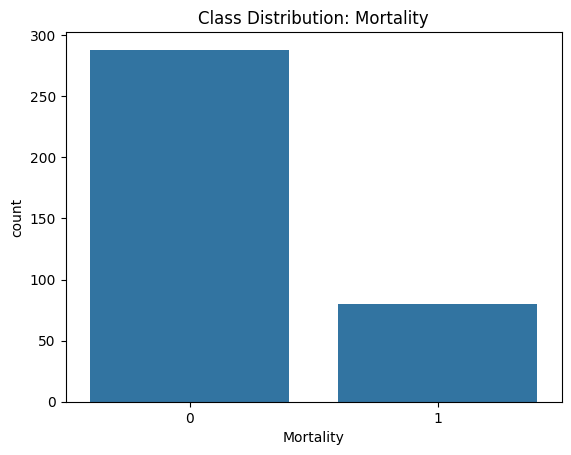

In [3]:
df.describe()

# Assuming 'Mortality' is the target
sns.countplot(x='Mortality', data=df)
plt.title('Class Distribution: Mortality')
plt.show()

# In[4] - Duplicate Check & Correlation Heatmap

Duplicates: 214


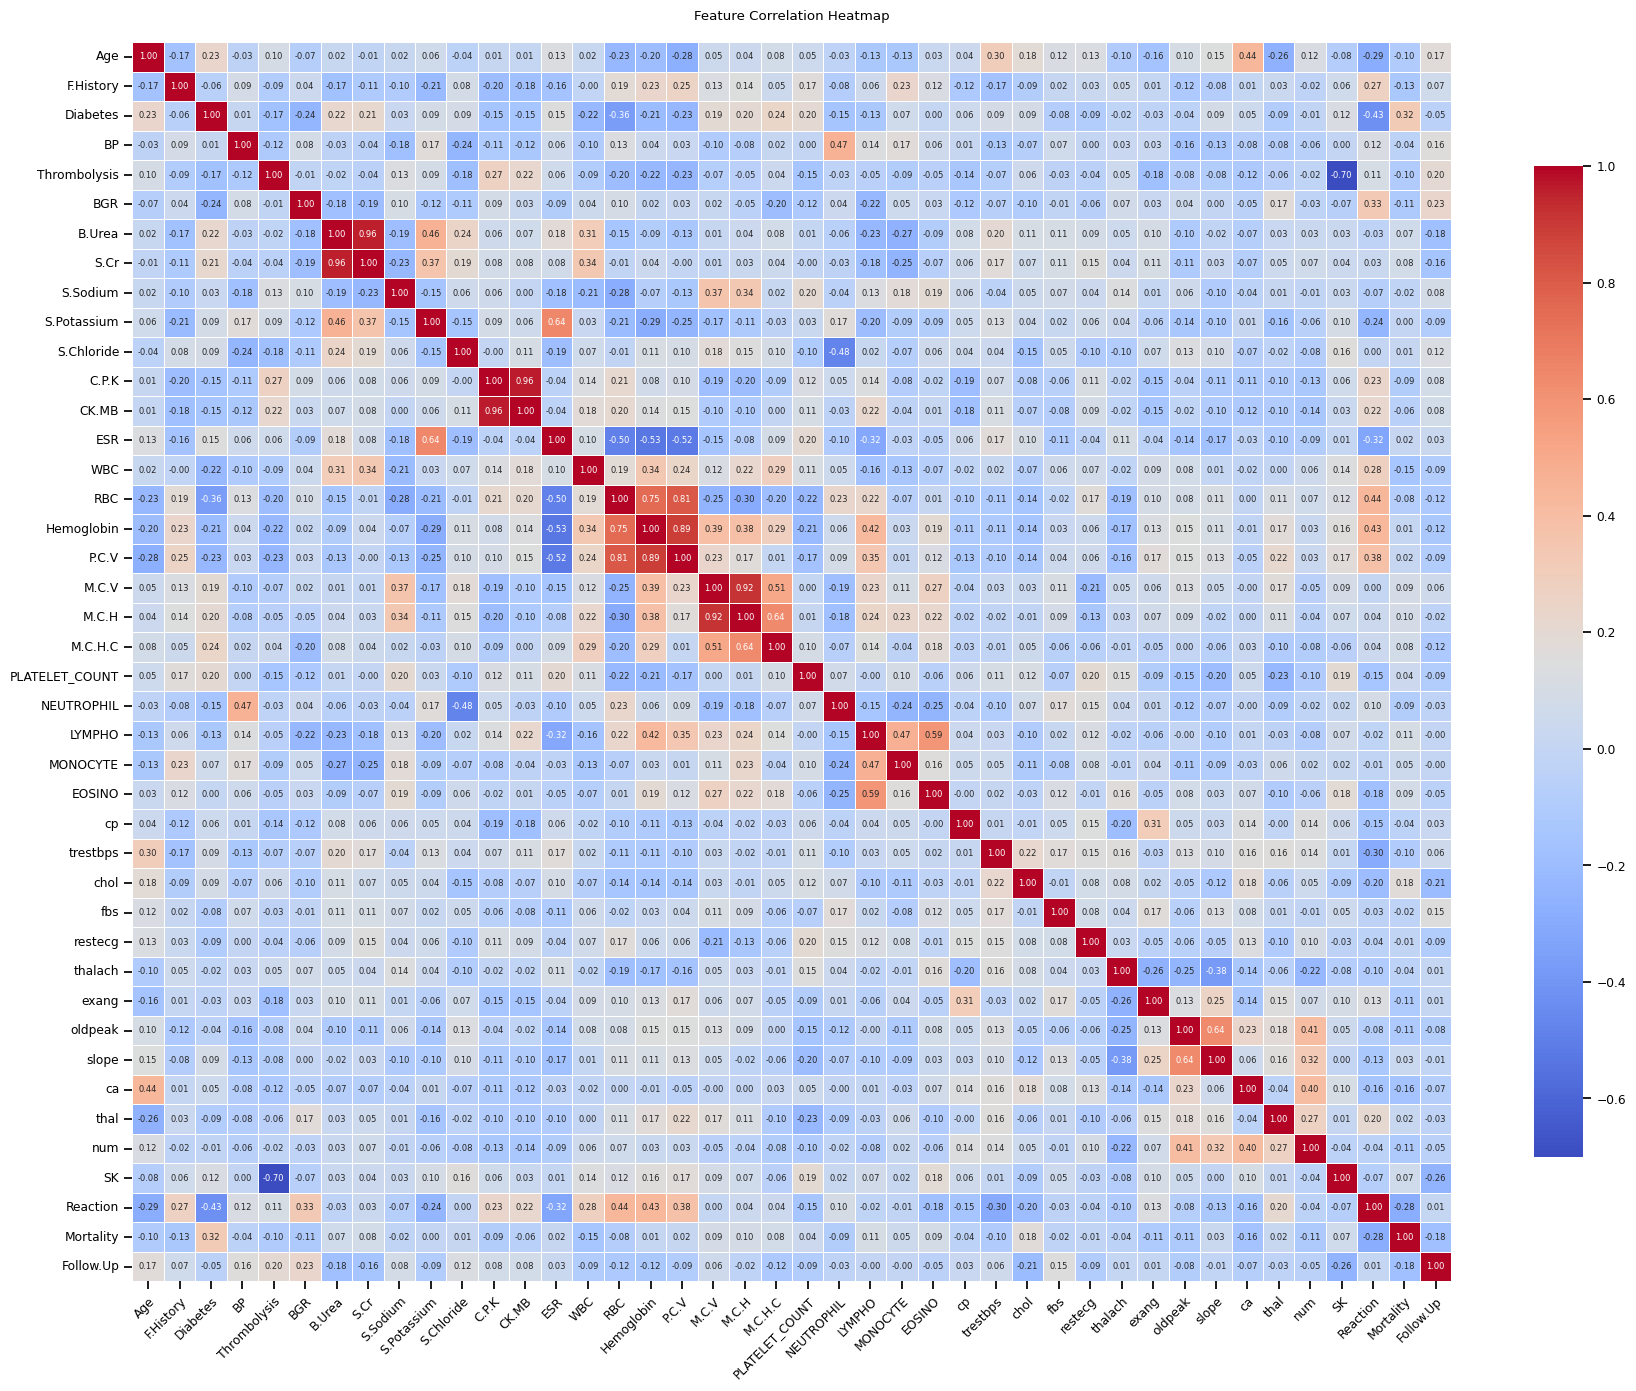

In [23]:
print("Duplicates:", df.duplicated().sum())

# In[5] – Duplicate Check & Correlation Heatmap (fixed)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix
corr = df.select_dtypes(include=[np.number]).corr()

# Make the figure big enough
plt.figure(figsize=(18, 14))

# Optionally scale the fonts so the numbers fit
sns.set_context("notebook", font_scale=0.8)

# Draw the heatmap
ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={"shrink": .8},
    linewidths=.5,
    annot_kws={"size": 6}
)

# Rotate the x-labels and align
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.title("Feature Correlation Heatmap", pad=16)
plt.tight_layout()
plt.show()


# In[5] - Train/Test Split & Preprocessing Setup

In [24]:
from sklearn.pipeline import Pipeline

X = df.drop('Mortality', axis=1)
y = df['Mortality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_cols = X.select_dtypes(include=np.number).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, num_cols)]
)

# In[6] - Modeling & Hyperparameter Grids

In [25]:
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'params': {'clf__C': [0.01, 0.1, 1, 10]}
    },
    'Random Forest': {
        'model': RandomForestClassifier(class_weight='balanced'),
        'params': {
            'clf__n_estimators': [50, 100, 200],
            'clf__max_depth': [None, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'clf__n_estimators': [50, 100],
            'clf__learning_rate': [0.01, 0.1]
        }
    },
    'SVM': {
        'model': SVC(class_weight='balanced', probability=True),
        'params': {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'clf__n_neighbors': [3, 5, 7],
            'clf__weights': ['uniform', 'distance']
        }
    }
}

# In[7] - Grid Search, Training & Evaluation

In [26]:
results = []

for name, mp in models.items():
    pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', mp['model'])
    ])
    grid = GridSearchCV(
        pipe,
        param_grid=mp['params'],
        scoring='f1',
        cv=2,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)[:, 1]
    
    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': best.score(X_test, y_test),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results).set_index('Model')
results_df

,Best Params,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,,
Logistic Regression,{'clf__C': 10},0.878378,0.652174,0.9375,0.769231,0.885776
Random Forest,"{'clf__max_depth': 5, 'clf__n_estimators': 100}",0.972973,0.937500,0.9375,0.937500,0.994612
Gradient Boosting,"{'clf__learning_rate': 0.1, 'clf__n_estimators...",0.972973,0.937500,0.9375,0.937500,0.997845
SVM,"{'clf__C': 10, 'clf__kernel': 'rbf'}",0.959459,0.933333,0.8750,0.903226,0.940733
KNN,"{'clf__n_neighbors': 3, 'clf__weights': 'dista...",0.918919,0.777778,0.8750,0.823529,0.901940


# In[8] - Final Results Table

In [27]:
results_df

,Best Params,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,,
Logistic Regression,{'clf__C': 10},0.878378,0.652174,0.9375,0.769231,0.885776
Random Forest,"{'clf__max_depth': 5, 'clf__n_estimators': 100}",0.972973,0.937500,0.9375,0.937500,0.994612
Gradient Boosting,"{'clf__learning_rate': 0.1, 'clf__n_estimators...",0.972973,0.937500,0.9375,0.937500,0.997845
SVM,"{'clf__C': 10, 'clf__kernel': 'rbf'}",0.959459,0.933333,0.8750,0.903226,0.940733
KNN,"{'clf__n_neighbors': 3, 'clf__weights': 'dista...",0.918919,0.777778,0.8750,0.823529,0.901940
